In [62]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sequences/sequences2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import torch
import dataset_flickr7k
import helper_classes as helper
import nltk
from torch.utils.data import Dataset, DataLoader
nltk.download('punkt')

import importlib 
import model_attn_2 as model_attn
importlib.reload(model_attn)

import torch.nn as nn
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

test_data = dataset_flickr7k.Flickr7kData(**data_args)
pad_idx = test_data.vocabulary.str_to_idx["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

length = 2000
stage:  test
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/test
Initialized 7736 words in vocabulary


device(type='cuda')

# Encoder Decoder Attention Tests

In [65]:
# Load model for inference 
embed_size = 256
hidden_size = 512
attn_dim = 256 
num_layers = 1
vocab_size = len(test_data.vocabulary)

attention_test_model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
helper.load_model(attention_test_model, "attention_model.pth")



Initialized Encoder!
Initialized Decoder!
Loaded from model attention_model.pth!


## BLEU-4 Score

In [66]:
test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
    )

In [67]:
# Test bleu score for one sample

attention_test_model.eval()

idx, X, y= next(iter(test_loader))
X = X.to(device)
features = attention_test_model.encoder(X)

captions = test_data.get_all_captions(idx.item())
print(captions)
longest_caption = max(captions, key=len)
len_ref = len(longest_caption)

predicted = attention_test_model.generate_caption(features, test_data.vocabulary, len_ref)
print(predicted)

score = helper.get_bleu_4_score(captions, predicted)
print(score)


['Different people buying , and looking at different kinds of vegetables and flowers .', "A small group of people are looking over vegetables at a farmer 's market .", "Customers are shopping for produce at a farmer 's market .", 'Outdoor market selling fruit and vegetables .', 'Shoppers pick fresh fruit beneath a tent .']
a group of people are standing in a market .
0.794059468056965


In [68]:
# Test Bleu score

score_total = 0

for batch_num, (idx, X, y) in enumerate(test_loader):
    X = X.to(device)
    features = attention_test_model.encoder(X)

    captions = test_data.get_all_captions(idx.item())

    longest_caption = max(captions, key=len)
    len_ref = len(longest_caption)

    predicted = attention_test_model.generate_caption(features, test_data.vocabulary, len_ref)

    score = helper.get_bleu_4_score(captions, predicted)
    score_total += score


    if batch_num%1000 == 0:
        average = score_total/(batch_num+1)
        print(f"Batch # {batch_num}. Bleu Score Average: {average}")

print(f"Batch # {batch_num}. Bleu Score Average: {average}")

Batch # 0. Bleu Score Average: 0.7146454716302961
Batch # 1000. Bleu Score Average: 0.5598519473356565


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Batch # 2000. Bleu Score Average: 0.5572929413316895
Batch # 3000. Bleu Score Average: 0.5575749624613595
Batch # 4000. Bleu Score Average: 0.5571568110272069
Batch # 5000. Bleu Score Average: 0.557985585946299
Batch # 6000. Bleu Score Average: 0.5585302150043212
Batch # 7000. Bleu Score Average: 0.5598685316454534
Batch # 8000. Bleu Score Average: 0.5594246123528612
Batch # 9000. Bleu Score Average: 0.5587262562008729
Batch # 9999. Bleu Score Average: 0.5587262562008729


## Sample captions

In [69]:
def sample_caption(idx):
    plt.imshow(test_data.plot_img(idx.item()))
    expected = test_data.get_all_captions(idx.item())

    longest_caption = max(expected, key=len)
    longest = len(longest_caption)

    print("Captions: ")
    for e in expected:
        print(e)

    print("\nPredicted: ", attention_test_model.generate_caption(features, test_data.vocabulary, longest))
    plt.show()

Captions: 
A smiling young man stands underneath a waterfall with his raised arms open wide .
A black man is watching another black man playing in the waterfall .
A shirtless man has his arms wide open near a waterfall .
A man bathes in a waterfall as another man looks on .
Two people at the base of a waterfall .

Predicted:  a man in a red shirt and blue jeans is walking down a dirt road .


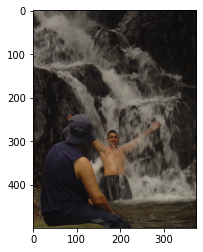

Captions: 
A girl is outside a house with a pink hula hoop spinning around her upper leg .
Child playing with a hula hoop on a cement driveway in housing alotment .
A young girl stands barefoot on a driveway and uses a hula-hoop .
A girl poses on a shady driveway .
A girl stands in a driveway .

Predicted:  a man in a red shirt and blue jeans is walking down a dirt road .


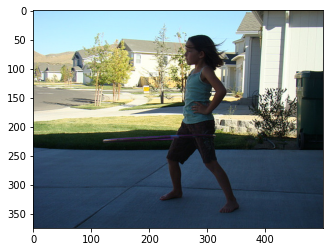

Captions: 
a lone person in a red boat on a wild river with only one padel
This person in a red kayak faces a challange in the rapids .
A kayaker crashes against the force of the wave .
A man pilots a kayak through rough rapids .
A person riverrafting .

Predicted:  a man in a red shirt and blue jeans is walking down a dirt road .


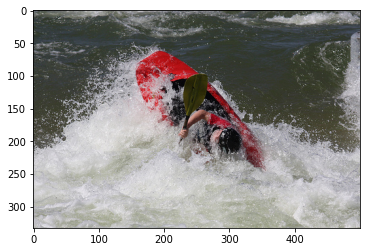

In [70]:
for _ in range(3):
    idx, X, y= next(iter(test_loader))
    sample_caption(idx)

## Loss 

In [71]:
# Set up variables for loss calculation
test_loader_100 = DataLoader(
        dataset=test_data,
        batch_size=  100,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx)
    )

criterion = nn.CrossEntropyLoss(ignore_index=test_data.vocabulary.str_to_idx["<PAD>"])

In [72]:
batch_loss = 0

for batch_num, (idx, X, y) in enumerate(test_loader_100):
    X = X.to(device)
    y = y.to(device)

    y_train = y.to(device)
    outputs = attention_test_model(X, y_train)
    y_target = y[:, 1:].to(device)
    
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), 
        y_target.reshape(-1)
    )
    
    batch_loss += loss.item()

avg_batch_loss = batch_loss/(batch_num+1)

print(f'Average loss: {avg_batch_loss}')

Average loss: 3.081378560066223


# Encoder Decoder (No Attention) Tests

In [73]:
import model
importlib.reload(model)
embed_size = 256
hidden_size = 256
attn_dim = 256 
num_layers = 1
extract_features = True
vocab_size = len(test_data.vocabulary)

basic_test_model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
helper.load_model(basic_test_model, "basic_model.pth")

Initialized Encoder!
Initialized Decoder!
Loaded from model basic_model.pth!


## BLEU-4 Score

In [74]:
# Test bleu score for one sample
basic_test_model.eval()

idx, X, y= next(iter(test_loader))
X = X.to(device)
features = basic_test_model.encoder(X)

captions = test_data.get_all_captions(idx.item())
print(captions)
longest_caption = max(captions, key=len)
len_ref = len(longest_caption)

predicted = basic_test_model.caption_image(X, test_data.vocabulary, len_ref)
print(predicted)

score = helper.get_bleu_4_score(captions, predicted)
print(score)

['Four guys including one with a black backpack , one drinking coffee , one in a red shirt and one with a gray shirt are watching Elmo on tv .', 'Four young men sit on the floor close to a television that is showing Elmo from Sesame Street .', 'College aged adults watching Elmo on large television .', 'Four grown men watching Elmo on a television .', 'Young men watching Sesame Street .']
a man in a blue shirt is sitting on a bench .
0.6566329061413897


In [75]:
# Test Bleu score

score_total = 0

for batch_num, (idx, X, y) in enumerate(test_loader):
    X = X.to(device)
    features = basic_test_model.encoder(X)

    captions = test_data.get_all_captions(idx.item())
    longest_caption = max(captions, key=len)
    len_ref = len(longest_caption)

    predicted = basic_test_model.caption_image(X, test_data.vocabulary, len_ref)
    
    score = helper.get_bleu_4_score(captions, predicted)

    score_total += score


    if batch_num%1000 == 0:
        average = score_total/(batch_num+1)
        print(f"Batch # {batch_num}. Bleu Score Average: {average}")

print(f"Batch # {batch_num}. Bleu Score Average: {average}")



Batch # 0. Bleu Score Average: 0.41256253410918825
Batch # 1000. Bleu Score Average: 0.5192427372596892
Batch # 2000. Bleu Score Average: 0.5220210824228952
Batch # 3000. Bleu Score Average: 0.5207225234810399
Batch # 4000. Bleu Score Average: 0.5211730293791964
Batch # 5000. Bleu Score Average: 0.5194733165797024
Batch # 6000. Bleu Score Average: 0.5190937213303944
Batch # 7000. Bleu Score Average: 0.5192977238024858
Batch # 8000. Bleu Score Average: 0.5193182437023538
Batch # 9000. Bleu Score Average: 0.5197549679134238
Batch # 9999. Bleu Score Average: 0.5197549679134238


## Sample Captions

In [76]:
def basic_sample_caption(idx, X):
    plt.imshow(test_data.plot_img(idx.item()))
    expected = test_data.get_all_captions(idx.item())

    longest_caption = max(expected, key=len)
    longest = len(longest_caption)

    print("Captions: ")
    for e in expected:
        print(e)

    predicted = basic_test_model.caption_image(X, test_data.vocabulary, longest)
    print("\nPredicted: ", predicted)
    plt.show()

Captions: 
A man in a striped shirt hugging a blond short-haired woman with a black apron on .
A man in a striped shirt poses with a blond girl in a black apron .
A man is standing next to a woman , with his arm around her waist .
A man with glasses is standing next to a woman with blond-hair .
A man and a woman in a brown room posing for the camera .

Predicted:  a man in a blue shirt is sitting on a bench .


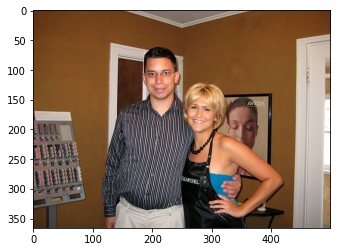

Captions: 
A view of a few people , mostly wearing dark colors , crossing a city crosswalk .
People are walking while one male has his head turned to the left side .
A group of people in dark clothing are crossing a crosswalk .
group of people dressed in black crossing city street
Several men wearing suits in an urban environment .

Predicted:  a man in a blue shirt and jeans is standing in front of a building .


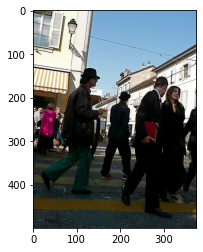

Captions: 
through the power lines , a man sits near an unusual shaped tree stump
Little boy sitting on the sidewalk outside .
A man is sitting on the sidewalk by a tree .
A man sitting on a curb in a city park .
A man sits on a sidewalk .

Predicted:  a man in a blue shirt and jeans is standing on a ladder .


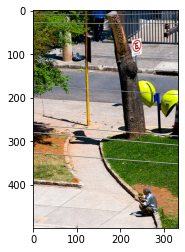

In [77]:
for _ in range(3):
    idx, X, y= next(iter(test_loader))
    X = X.to(device)
    basic_sample_caption(idx, X)


## Loss

In [84]:
# Set up variables for loss calculation
test_loader_100 = DataLoader(
        dataset=test_data,
        batch_size=  100,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx, batch_first=False)
    )

criterion = nn.CrossEntropyLoss(ignore_index=test_data.vocabulary.str_to_idx["<PAD>"])

In [85]:
batch_loss = 0

for batch_num, (idx, X, y) in enumerate(test_loader_100):
    X = X.to(device)
    y = y.to(device)

    outputs = basic_test_model(X, y[:-1])

    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), y.reshape(-1)
    )

    batch_loss += loss.item()


avg_batch_loss = batch_loss/(batch_num+1)
print(f'Average loss: {avg_batch_loss}')

Average loss: 2.9828386449813844
